# PART 3: Convexity Correction

Group Members: 
1. Harshita Sachdev
2. Lu Tinjia
3. Rahul Sreeram
4. Srivatsa Sanjiv Mitragotri
5. Xie Zuoyu
6. Zhang Yonghan
7. Zhao Geping


For static replication of any constant maturity swap (CMS) payoff $g(F)$, where $F$ is the swap rate, we use the following formula:

  \begin{equation*}
    \begin{split}
      V_0 &= D(0,T) g(F) + h'(F)[V^{pay}(F)-V^{rec}(F)] \\
      &\;\;\;\;\;\;\;\;\;\;+ \int_0^F h''(K) V^{rec}(K) dK +
      \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

where

  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\mbox{IRR}(K)} \\
      h'(K) &= \frac{\mbox{IRR}(K)g'(K) - g(K)\mbox{IRR}'(K)}{\mbox{IRR}(K)^2} \\
      h''(K) &= \frac{\mbox{IRR}(K)g''(K)-\mbox{IRR}''(K)g(K) -2\cdot\mbox{IRR}'(K)g'(K)}{\mbox{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\mbox{IRR}'(K)^2g(K)}{\mbox{IRR}(K)^3}.
    \end{split}
  \end{equation*}
  
For CMS rate payoff, the payoff function can be defined simply as $g(F)=F$, and the static replication formula simplifies into:

  \begin{equation*}
    \begin{split}
      D(0,T) F + \int_0^F h''(K) V^{rec}(K) dK + \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}



Let $m$ denote the payment frequenc ($m=2$ for semi-annual payment frequency), and let $N = T_N-T_n$ denote the tenor of the swap (number of years), the partial derivatives on the IRR function $\mbox{IRR}(S)$ given by:
\begin{equation*}
\begin{split}
\mbox{IRR}(K)&=\sum_{i=1}^{N\times m}\frac{1}{(1+\frac{K}{m})^i}=\frac{1}{K}\left[1-\frac{1}{\left(1+\frac{K}{m}\right)^{N\times m}}\right]\\
\mbox{IRR}'(K)&=-\frac{1}{K}\mbox{IRR}(K)
+\frac{1}{m\times K}\frac{N\times m}{\left(1+\frac{K}{m}\right)^{N\times m+1}} \\
\mbox{IRR}''(K)&=-\frac{2}{K}\mbox{IRR}'(K)
-\frac{1}{m^2\times K}\frac{N\time1s m\cdot (N\times m+1)}{\left(1+\frac{K}{m}\right)^{N\times m+2}} \\
\end{split}
\end{equation*}

These results will need to be generalised to handle the case for $m=2$ to be consistent with the semi-annual payment frequency swap market data provided.


For CMS rate payment, since $g(F)=F$, we have the derivatives:

\begin{equation*}
\begin{split}
g(K) &= K \\
g'(K) &= 1 \\
g''(K) &= 0
\end{split}
\end{equation*}

In [5]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.integrate import quad


In [6]:
def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0


def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative

def h_0(K, m, tenor):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, tenor)
    return value

def h_1(K, m, tenor):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, tenor)*g_1(K) - g_0(K)*IRR_1(K, m, tenor)) / IRR_0(K, m, tenor)**2
    return firstDerivative

def h_2(K, m, tenor):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, tenor)*g_2(K) - IRR_2(K, m, tenor)*g_0(K) - 2.0*IRR_1(K, m, tenor)*g_1(K))/IRR_0(K, m, tenor)**2 
                        + 2.0*IRR_1(K, m, tenor)**2*g_0(K)/IRR_0(K, m, tenor)**3)
    return secondDerivative

We will also need to implement the IRR-settled payer and receiver swaption formulae:

  \begin{equation*}
    \begin{split}
      V^{pay}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Call}(S_{n,N}(0),K,\sigma_{n,N},T) \\
      V^{rec}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Put}(S_{n,N}(0),K,\sigma_{n,N},T) \\
    \end{split}
  \end{equation*}

where $S_{n,N}(0)=F$ is today's forward swap rate calculated based on the curves we bootstrapped, and $\sigma_{n,N}$ is the SABR implied volatility calibrated to swaption market data.

## Calculating PV of CMS10y and CMS2y
Using the SABR model calibrated in the previous question, value the
following constant maturity swap (CMS) products:

• PV of a leg receiving CMS10y semi-annually over the next 5 years

• PV of a leg receiving CMS2y quarterly over the next 10 years

In [9]:
# Load necessary data from previous parts

D_OIS = pd.read_csv('ois_result.csv')
D_LIBOR = pd.read_csv('LIBOR.csv')

In [10]:
D_OIS.head()

,Tenor,Rate,Discount Factor
0,0.5,0.002500,0.999993
1,1.0,0.003000,0.997009
2,1.5,0.003125,0.995270
3,2.0,0.003250,0.993531
4,2.5,0.003300,0.991773


In [11]:
D_LIBOR.head()

,Unnamed: 0,Tenor,Product,Rate,Discount Factor
0,0,0.5,6m,0.02500,1.000000
1,1,1.0,1y,0.02800,0.972763
2,2,1.5,NaN,0.02900,0.957652
3,3,2.0,2y,0.03000,0.942541
4,4,2.5,NaN,0.03075,0.926757


In [12]:


## Linear interpolate  DF
def interpolate_discount(T, df):
    x = list(df['Tenor'])
    y = list(df['Discount Factor'])
    return np.interp(T, x, y)

#SABR Params from part 2
sabr_params = {
    (1, 1): (0.0068, 0.1, 0.2928),
    (1, 2): (0.0102, 0.1, 0.2914),   
    (1, 3): (0.0112, 0.1, 0.3013),   
    (1, 5): (0.0096, 0.1, 0.4338),  
    (1, 10): (0.0104, 0.1, 0.4929),
    (5, 2): (0.0118, 0.1, 0.2735),
    (5, 3): (0.0122, 0.1, 0.2925),   
    (5, 5): (0.0111, 0.1, 0.3786),  
    (5, 10): (0.0119, 0.1208, 0.8254),
    (10, 1): (0.0122, 0.1, 0.1822),
    (10, 2): (0.0134, 0.1, 0.1720),
    (10, 3): (0.0164, 0.1, 0.8055),
    (10, 5): (0.0148, 0.1, 0.8473),
    (10, 2): (0.0126, 0.1, 0.3007),  
}
# Function to interpolate SABR parameters
def get_sabr_params(expiry, tenor):
    expiries = sorted(set(e for (e, t) in sabr_params.keys() if t == tenor))
    if not expiries:
        raise ValueError(f"No SABR parameters for tenor {tenor}")
    if expiry in expiries:
        return sabr_params[(expiry, tenor)]
    # Linear interpolation between nearest expiries
    e_lower = max([e for e in expiries if e <= expiry], default=min(expiries))
    e_upper = min([e for e in expiries if e >= expiry], default=max(expiries))
    if e_lower == e_upper:
        return sabr_params[(e_lower, tenor)]
    alpha_low, nu_low, rho_low = sabr_params[(e_lower, tenor)]
    alpha_high, nu_high, rho_high = sabr_params[(e_upper, tenor)]
    weight = (expiry - e_lower) / (e_upper - e_lower)
    alpha = alpha_low + weight * (alpha_high - alpha_low)
    nu = nu_low + weight * (nu_high - nu_low)
    rho = rho_low + weight * (rho_high - rho_low)
    return (alpha, nu, rho)


In [13]:

# SABR volatility function

def sabr_vol(F, K, T, alpha, beta, rho, nu):
    if F == K:
        # Handle ATM case
        term1 = ( (1 - beta)**2 * alpha**2 ) / (24 * F**(2 * (1 - beta)) )
        term2 = ( rho * beta * nu * alpha ) / (4 * F**(1 - beta) )
        term3 = ( (2 - 3 * rho**2 ) * nu**2 ) / 24
        vol = (alpha / (F ** (1 - beta))) * (1 + (term1 + term2 + term3) * T )
    else:
        # Handle OTM case
        z = (nu / alpha) * (F * K)**((1 - beta)/2) * np.log(F / K)
        x = np.log( (np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho) )
        term1 = ( (1 - beta)**2 * alpha**2 ) / (24 * (F * K)**(1 - beta))
        term2 = ( rho * beta * nu * alpha ) / (4 * (F * K)**((1 - beta)/2) )
        term3 = ( (2 - 3 * rho**2 ) * nu**2 ) / 24
        main = (alpha / ( (F * K)**((1 - beta)/2) * (1 + ( (1 - beta)**2 / 24 ) * (np.log(F/K))**2 ) )) 
        vol = main * (z / x) * (1 + (term1 + term2 + term3) * T )
    return vol
           
# Black76 price
def black76(F, K, sigma, T, is_payer=True):
    d1 = (np.log(F / K) + (0.5 * sigma**2 * T)) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if is_payer:
        price = F * norm.cdf(d1) - K * norm.cdf(d2)
    else:
        price = K * norm.cdf(-d2) - F * norm.cdf(-d1)
    return price

def Forward_LIBOR(m, D1, D2):
    return m * ((D1 - D2) / D2)

## IRR-Settled payer and recevier swaption integrant at time T
def Rec_Integral(F, K, m, tenor, t, sigma):
    return h_2(K, m, tenor) * black76(F, K, t, sigma, is_payer=False)

def Pay_Integral(F, K, m, tenor, t, sigma):
    return h_2(K, m, tenor) * black76(F, K, t, sigma, is_payer=True)

## Calculate swap rate
def Forward_Swap_Rate(expiry, tenor, m):
    floated, fix = 0, 0
    for i in range(1, int(tenor * m)+1):
        end = expiry + i/m
        floated += interpolate_discount(end,D_OIS ) * Forward_LIBOR(m, interpolate_discount(end-1/m, D_LIBOR), interpolate_discount(end, D_LIBOR)) * 1/m
        fix += interpolate_discount(expiry + i/m, D_OIS)/m
    return floated/fix
    
## Calculate the CMS rate
def CMS(m, tenor, expiry):
    F = Forward_Swap_Rate(expiry, tenor, m)
    alpha, nu, rho = get_sabr_params(expiry, tenor)
    CMS = F + quad(lambda x: Rec_Integral(F, x, m, tenor ,expiry, sabr_vol(F,x,expiry,alpha,0.9,rho,nu)), 0, F)[0]\
            + quad(lambda x: Pay_Integral(F, x, m, tenor ,expiry, sabr_vol(F,x,expiry,alpha,0.9,rho,nu)), F, 0.1)[0]
    return CMS
    
# Calculate PV of CMS legs
def cms_leg_pv(m, tenor, expiry):
    n = int(expiry*m)
    pv = 0
    for i in range(1,n+1):
        ti = i/m
        pv += (interpolate_discount(ti,D_OIS)/m) * CMS(m, tenor, expiry)
    return pv

# Example usage for CMS10y semi-annually over 5 years
pv_cms10y = cms_leg_pv(2,10, 5 )
print(f"PV of CMS10y leg: {pv_cms10y:.4f}")

# For CMS2y quarterly over 10 years
pv_cms2y = cms_leg_pv(2,2,10)
print(f"PV of CMS2y leg: {pv_cms2y:.4f}")



PV of CMS10y leg: 0.2135
PV of CMS2y leg: 0.4269


## Compare the forward swap rates with the CMS rate:

• 1y × 1y, 1y × 2y, 1y × 3y, 1y × 5y, 1y × 10y

• 5y × 1y, 5y × 2y, 5y × 3y, 5y × 5y, 5y × 10y

• 10y × 1y, 10y × 2y, 10y × 3y, 10y × 5y, 10y × 10y


Comparison Table:
    Expiry  Tenor  Forward Swap Rate  Convexity Correction  CMS Rate
0        1      1           0.031811              0.000009  0.031820
1        1      2           0.033082              0.000012  0.033094
2        1      3           0.033852              0.000012  0.033864
3        1      5           0.035043              0.000011  0.035054
4        1     10           0.037802              0.000015  0.037817
5        5      1           0.038823              0.000741  0.039564
6        5      2           0.039606              0.000735  0.040341
7        5      3           0.039438              0.000715  0.040153
8        5      5           0.040281              0.000697  0.040978
9        5     10           0.042205              0.000887  0.043092
10      10      1           0.040428              0.002446  0.042874
11      10      2           0.041279              0.002165  0.043444
12      10      3           0.042179              0.002306  0.044485
13      10     

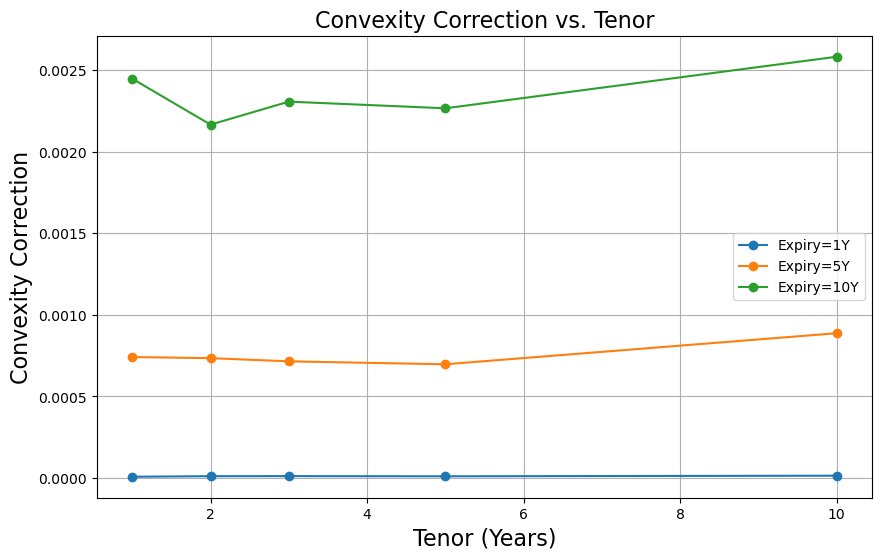

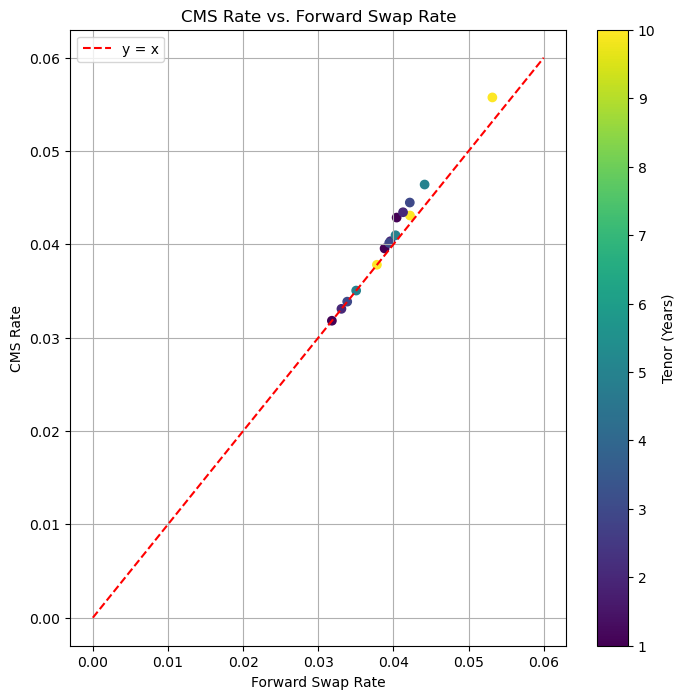

In [25]:
 import matplotlib.pyplot as plt

# Load forward swap rates from Part I (Table 1)
forward_swap_rates = [
    {'Expiry': 1, 'Tenor': 1, 'Rate': 0.031811},
    {'Expiry': 1, 'Tenor': 2, 'Rate': 0.033082},
    {'Expiry': 1, 'Tenor': 3, 'Rate': 0.033852},
    {'Expiry': 1, 'Tenor': 5, 'Rate': 0.035043},
    {'Expiry': 1, 'Tenor': 10, 'Rate': 0.037802},
    {'Expiry': 5, 'Tenor': 1, 'Rate': 0.038823},
    {'Expiry': 5, 'Tenor': 2, 'Rate': 0.039606},
    {'Expiry': 5, 'Tenor': 3, 'Rate': 0.039438},
    {'Expiry': 5, 'Tenor': 5, 'Rate': 0.040281},
    {'Expiry': 5, 'Tenor': 10, 'Rate': 0.042205},
    {'Expiry': 10, 'Tenor': 1, 'Rate': 0.040428},
    {'Expiry': 10, 'Tenor': 2, 'Rate': 0.041279},
    {'Expiry': 10, 'Tenor': 3, 'Rate': 0.042179},
    {'Expiry': 10, 'Tenor': 5, 'Rate': 0.044149},
    {'Expiry': 10, 'Tenor': 10, 'Rate': 0.053165},
]


# Calculate CMS rates
results = []
for rate in forward_swap_rates:
    expiry = rate['Expiry']
    tenor = rate['Tenor']
    forward_rate = rate['Rate']
    try:
        cms_rate = CMS(m=2, tenor=tenor, expiry=expiry)
        convexity_adjustment = cms_rate - forward_rate
        results.append({
            'Expiry': expiry,
            'Tenor': tenor,
            'Forward Swap Rate': forward_rate,
            'Convexity Correction': convexity_adjustment,
            'CMS Rate': cms_rate
        })
    except Exception as e:
        print(f"Skipping {expiry}Y x {tenor}Y: {str(e)}")

# Convert to DataFrame
df_comparison = pd.DataFrame(results)
print("\nComparison Table:")
print(df_comparison)

# Plot Convexity Correction vs. Tenor
plt.figure(figsize=(10, 6))
for expiry in df_comparison['Expiry'].unique():
    subset = df_comparison[df_comparison['Expiry'] == expiry]
    plt.plot(subset['Tenor'], subset['Convexity Correction'], 
             marker='o', label=f'Expiry={expiry}Y')
plt.title('Convexity Correction vs. Tenor', fontsize=16)
plt.xlabel('Tenor (Years)', fontsize=16)
plt.ylabel('Convexity Correction', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Plot CMS Rate vs. Forward Swap Rate
plt.figure(figsize=(8, 8))
plt.scatter(df_comparison['Forward Swap Rate'], df_comparison['CMS Rate'], 
            c=df_comparison['Tenor'], cmap='viridis')
plt.plot([0, 0.06], [0, 0.06], 'r--', label='y = x')
plt.colorbar(label='Tenor (Years)')
plt.title('CMS Rate vs. Forward Swap Rate')
plt.xlabel('Forward Swap Rate')
plt.ylabel('CMS Rate')
plt.legend()
plt.grid(True)
plt.show()
